In [8]:
import os
#import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display_html

#sys.path.append(os.pardir)
dataFilePath = os.pardir + '/datafiles/'

%run ./../helpers/tableDecorator.ipynb

#Define data files
trainFile                =       "train.csv"
testFile                 =       "test.csv"
gender_submissionFile    =       "gender_submission.csv"


In [2]:
#Display tables for intermediate steps
displayStepTables = True

In [22]:
# Load data files
nRows = 5
showSamples = False  #selects random nRow rows. If set to False, displays nRow rows from head and nRow rows from tail 
highlightNA = True  #self expalanatory

dataTrain = pd.read_csv(dataFilePath + trainFile)
tF = applyStyle_01(dataTrain, nRows=nRows, showSamples=showSamples, highlightNA=highlightNA, caption = "TITANIC AI: Train Data")

dataTest = pd.read_csv(dataFilePath + testFile)
teF = applyStyle_01(dataTest, nRows=nRows, showSamples=showSamples, highlightNA=highlightNA, caption = "TITANIC AI: Test Data")

dataGenderSub = pd.read_csv(dataFilePath + gender_submissionFile)
sF = applyStyle_01(dataGenderSub, nRows=nRows, showSamples=showSamples, highlightNA=highlightNA, caption = "TITANIC AI: Gender Submission Data")

#Explanation of data
#boat - Lifeboat (if survived)
#Boat and Body do not exist in dataset we use

dictDesc = { 
    "Survived"              :        ["(0 = No; 1 = Yes)"],
    "PassengerId"           :        ["Passenger Id"],
    "Pclass"                :        ["Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)"],
    "Name"                  :        ["Name"],
    "Sex"                   :        ["Sex"],
    "Age"                   :        ["Age"],
    "SibSp"                 :        ["Number of Siblings/Spouses Aboard"],
    "Parch"                 :        ["Number of Parents/Children Aboard"],
    "Fare"                  :        ["Passenger Fare"],
    "Cabin"                 :        ["Cabin"],
    "Embarked"              :        ["Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)"],
    "Body"                  :        ["Body number (if did not survive and body was recovered)"]
}

dfDesc = pd.DataFrame().from_dict(dictDesc).T
descF = applyStyle_01(dfDesc, nRows=6, showSamples=False, highlightNA=False, caption = "TITANIC AI: Data Explanation")
if (displayStepTables):
    display(descF)

,0
Survived,(0 = No; 1 = Yes)
PassengerId,Passenger Id
Pclass,Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
Name,Name
Sex,Sex
Age,Age
SibSp,Number of Siblings/Spouses Aboard
Parch,Number of Parents/Children Aboard
Fare,Passenger Fare
Cabin,Cabin


In [76]:
if (displayStepTables):
    display(tF)
    display_html(teF._repr_html_()+sF._repr_html_(), raw=True)
    
    #Lets check number of null fields in Train and Test data
    display(applySeriesStyle_01(dataTest.isnull().sum(), "Train data columns with null values"))
    display(applySeriesStyle_01(dataTrain.isnull().sum(), "Test data columns with null values"))




,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.250000,S,2,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,71.283300,C,2,0,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.925000,S,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.100000,S,2,0,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.050000,S,1,1,Mr
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.000000,S,1,1,rare
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.000000,S,1,1,Miss
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.000000,1,2,23.450000,S,4,0,Miss
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.000000,C,1,1,Mr
890,0,3,"Dooley, Mr. Patrick",male,32.000000,0,0,7.750000,Q,1,1,Mr


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,3,"Kelly, Mr. James",male,34.500000,0,0,7.829200,Q,1,1,Mr
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.000000,S,2,0,Mrs
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.687500,Q,1,1,Mr
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,8.662500,S,1,1,Mr
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.287500,S,3,0,Mrs
413,3,"Spector, Mr. Woolf",male,28.000000,0,0,8.050000,S,1,1,Mr
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.900000,C,1,1,rare
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.250000,S,1,1,Mr
416,3,"Ware, Mr. Frederick",male,28.000000,0,0,8.050000,S,1,1,Mr
417,3,"Peter, Master. Michael J",male,28.000000,1,1,22.358300,C,3,0,Master


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,0,0,0,0,0,0,0,0,0,0,0


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,0,0,0,0,0,0,0,0,0,0,0,0


### Clean Data:
* We need to either delete or fill "nan" cells
* Age / Fare columns can be filled with median, or we can use ML estimation tools, such as Random Forest Regressor (TODO insert ref here)

* Cabin column is not easy to fill, for this study we don't want to increase complexity, this column will be dropped
* Passenger ID has no use with machine learning, will be dropped
* Similarly, the ticket code has no use with machine learning, will be dropped

In [70]:
def name_converted(feature):
    """
    This function helps modifying the title column
    """
    
    result = ''
    if feature in ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col', 'Rev', 'Dona', 'Dr']:
        result = 'rare'
    elif feature in ['Ms', 'Mlle']:
        result = 'Miss'
    elif feature == 'Mme':
        result = 'Mrs'
    else:
        result = feature
    return result

In [78]:
#Age:
dataTrain['Age'].fillna(dataTrain['Age'].median(), inplace = True)
dataTest['Age'].fillna(dataTrain['Age'].median(), inplace = True)
#Fare
dataTrain['Fare'].fillna(dataTrain['Fare'].median(), inplace = True)
dataTest['Fare'].fillna(dataTrain['Fare'].median(), inplace = True)
#Embarked - via mode
dataTrain['Embarked'].fillna(dataTrain['Embarked'].mode()[0], inplace = True)
dataTest['Embarked'].fillna(dataTrain['Embarked'].mode()[0], inplace = True)

#Drop not used columns from train set:
try:
    dataTrain.drop(['PassengerId','Cabin', 'Ticket'], axis=1, inplace = True)
except:
    if (displayStepTables):
        print("Fields already dropped")

#Drop not used columns from test set:
try:
    dataTest.drop(['PassengerId','Cabin', 'Ticket'], axis=1, inplace = True)
except:
    if (displayStepTables):
        print("Fields already dropped")


#Extract family size and add as a feature
dataTrain['FamilySize'] = dataTrain.SibSp + dataTrain.Parch+1
dataTest['FamilySize'] = dataTest.SibSp + dataTest.Parch+1

dataTrain['IsAlone'] = 1 
dataTrain['IsAlone'].loc[dataTrain['FamilySize'] > 1] = 0 
dataTest['IsAlone'] = 1 
dataTest['IsAlone'].loc[dataTest['FamilySize'] > 1] = 0 

## get the title from the name
dataTrain["title"] = [i.split('.')[0] for i in dataTrain.Name]
dataTrain["title"] = [i.split(',')[1] for i in dataTrain.title]
dataTrain.title = dataTrain.title.apply(lambda x: x.strip())

dataTest["title"] = [i.split('.')[0] for i in dataTest.Name]
dataTest["title"] = [i.split(',')[1] for i in dataTest.title]
dataTest.title = dataTest.title.apply(lambda x: x.strip())

dataTest.title = dataTest.title.map(name_converted)
dataTrain.title = dataTrain.title.map(name_converted)
if (displayStepTables):
    display(applySeriesStyle_01(dataTrain.isnull().sum(), "Train data columns with null values"))
    display(applySeriesStyle_01(dataTest.isnull().sum(), "Test data columns with null values"))

#print(dataTrain.title.unique())
#print(dataTest.title.unique())

#Dislay datasets one more time
tF = applyStyle_01(dataTrain, nRows=nRows, showSamples=showSamples, highlightNA=highlightNA, caption = "TITANIC AI: Train Data")
teF = applyStyle_01(dataTest, nRows=nRows, showSamples=showSamples, highlightNA=highlightNA, caption = "TITANIC AI: Test Data")
if (displayStepTables):
    display(tF)
    display(teF)

Fields already dropped
Fields already dropped


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,0,0,0,0,0,0,0,0,0,0,0,0


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,0,0,0,0,0,0,0,0,0,0,0


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.250000,S,2,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,71.283300,C,2,0,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.925000,S,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.100000,S,2,0,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.050000,S,1,1,Mr
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.000000,S,1,1,rare
887,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,30.000000,S,1,1,Miss
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.000000,1,2,23.450000,S,4,0,Miss
889,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,30.000000,C,1,1,Mr
890,0,3,"Dooley, Mr. Patrick",male,32.000000,0,0,7.750000,Q,1,1,Mr


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,title
0,3,"Kelly, Mr. James",male,34.500000,0,0,7.829200,Q,1,1,Mr
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,7.000000,S,2,0,Mrs
2,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,9.687500,Q,1,1,Mr
3,3,"Wirz, Mr. Albert",male,27.000000,0,0,8.662500,S,1,1,Mr
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,12.287500,S,3,0,Mrs
413,3,"Spector, Mr. Woolf",male,28.000000,0,0,8.050000,S,1,1,Mr
414,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,108.900000,C,1,1,rare
415,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,7.250000,S,1,1,Mr
416,3,"Ware, Mr. Frederick",male,28.000000,0,0,8.050000,S,1,1,Mr
417,3,"Peter, Master. Michael J",male,28.000000,1,1,22.358300,C,3,0,Master


### Visualize Data and check "Feature" relations

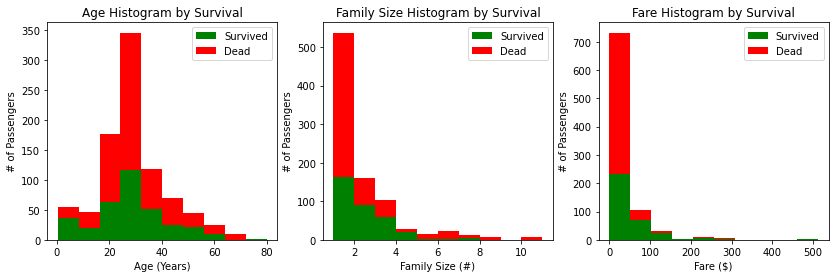

In [35]:
plt.figure(figsize=[14,4])

plt.subplot(131)
plt.hist(x = [dataTrain[dataTrain['Survived']==1]['Age'], dataTrain[dataTrain['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(132)
plt.hist(x = [dataTrain[dataTrain['Survived']==1]['FamilySize'], dataTrain[dataTrain['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(133)
plt.hist(x = [dataTrain[dataTrain['Survived']==1]['Fare'], dataTrain[dataTrain['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()
plt.show()

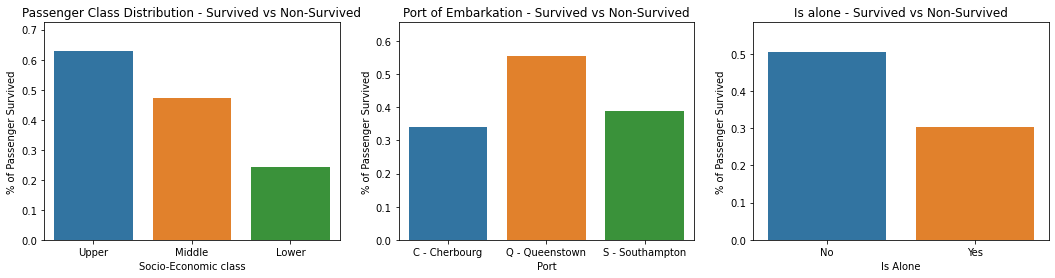

In [49]:
plt.figure(figsize=[18,4])

plt.subplot(131)
sns.barplot(x = "Pclass", 
            y = "Survived", 
            data=dataTrain, 
            linewidth=6,
            capsize = .05,
            errcolor='blue',
            errwidth = 0
           )
plt.title("Passenger Class Distribution - Survived vs Non-Survived")
plt.xlabel("Socio-Economic class");
plt.ylabel("% of Passenger Survived");
names = ['Upper', 'Middle', 'Lower']
val = [0,1,2] ## this is just a temporary trick to get the label right. 
plt.xticks(val, names);

plt.subplot(132)
sns.barplot(x = "Embarked", 
            y = "Survived", 
            data=dataTrain, 
            linewidth=6,
            capsize = .05,
            errcolor='blue',
            errwidth = 0
           )
plt.title("Port of Embarkation - Survived vs Non-Survived")
plt.xlabel("Port");
plt.ylabel("% of Passenger Survived");
names = ['C - Cherbourg', 'Q - Queenstown', 'S - Southampton']
val = [0,1,2] ## this is just a temporary trick to get the label right. 
plt.xticks(val, names);

plt.subplot(133)
sns.barplot(x = "IsAlone", 
            y = "Survived", 
            data=dataTrain, 
            linewidth=6,
            capsize = .05,
            errcolor='blue',
            errwidth = 0
           )
plt.title("Is alone - Survived vs Non-Survived")
plt.xlabel("Is Alone");
plt.ylabel("% of Passenger Survived");
names = ['No', 'Yes']
val = [0,1] ## this is just a temporary trick to get the label right. 
plt.xticks(val, names);


plt.show()

### Combined Feature Relations

C:\Users\lebuy\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


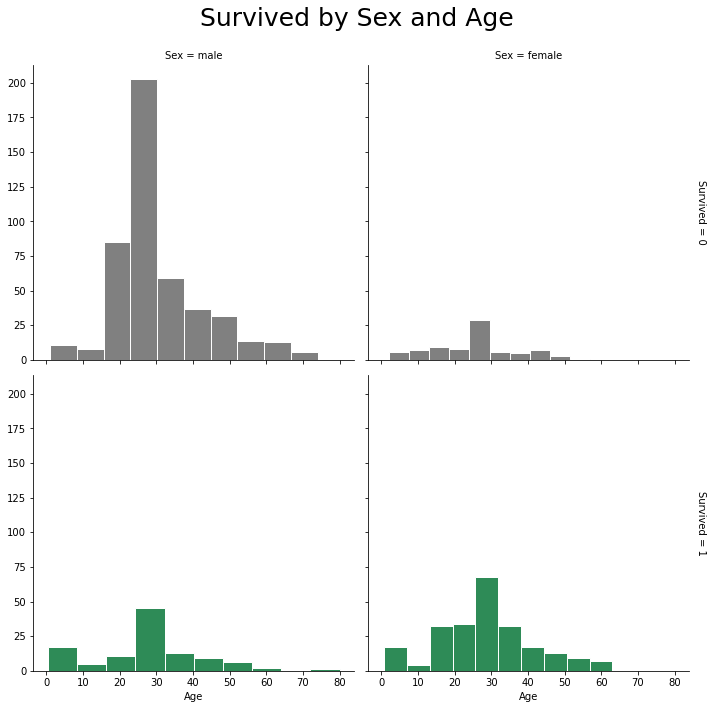

In [75]:

pal = {1:"seagreen", 0:"gray"}
g = sns.FacetGrid(dataTrain,size=5, col="Sex", row="Survived", margin_titles=True, hue = "Survived",
                  palette=pal)
g = g.map(plt.hist, "Age", edgecolor = 'white');
g.fig.suptitle("Survived by Sex and Age", size = 25)
plt.subplots_adjust(top=0.90)
plt.show()

C:\Users\lebuy\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


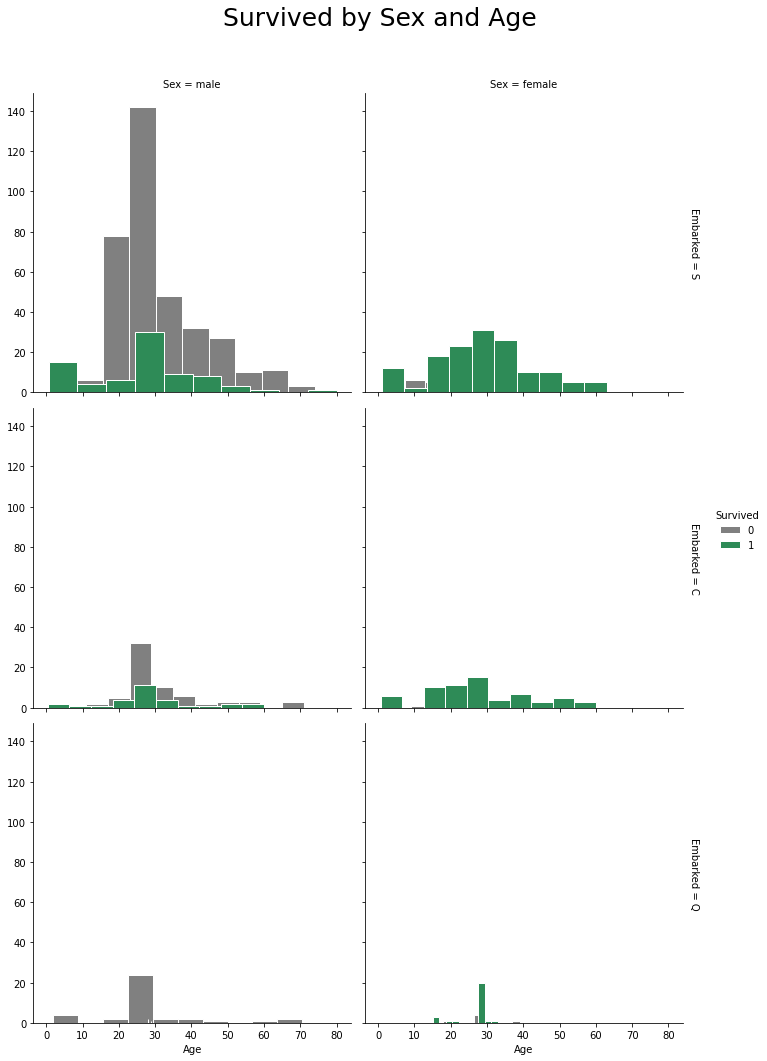

In [64]:
g = sns.FacetGrid(dataTrain,size=5, col="Sex", row="Embarked", margin_titles=True, hue = "Survived",
                  palette = pal
                  )
g = g.map(plt.hist, "Age", edgecolor = 'white').add_legend();
g.fig.suptitle("Survived by Sex and Age", size = 25)
plt.subplots_adjust(top=0.90)

C:\Users\lebuy\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


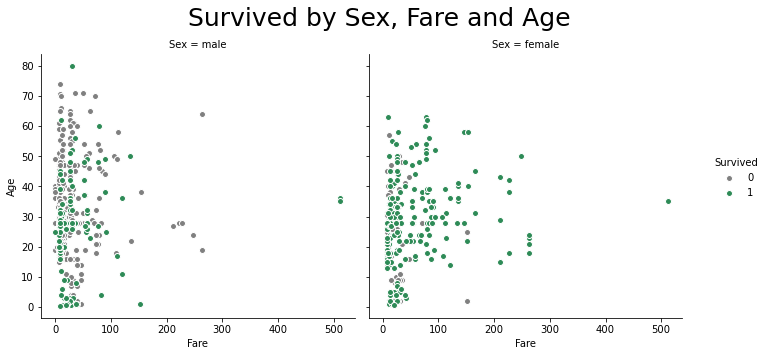

In [65]:
g = sns.FacetGrid(dataTrain, size=5,hue="Survived", col ="Sex", margin_titles=True,
                palette=pal,)
g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g.fig.suptitle("Survived by Sex, Fare and Age", size = 25)
plt.subplots_adjust(top=0.85)

### Correlation

In [66]:
if (displayStepTables):
    pd.DataFrame(abs(dataTrain.corr()['Survived']).sort_values(ascending = False))

,Survived
Survived,1.000000
Pclass,0.338481
Fare,0.257307
IsAlone,0.203367
Parch,0.081629
Age,0.064910
SibSp,0.035322
FamilySize,0.016639
